In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('../data.csv')

In [80]:
df2 = df.copy()

In [4]:
df.head()

,title,year,certificate,rating,description,director,writer,actors,genres,runtime
0,Transformers: Revenge of the Fallen,2009,PG-13,5.9,Sam Witwicky leaves the Autobots behind for a ...,Michael Bay,"Alex Kurtzman, Roberto Orci, Ehren Kruger","Shia LaBeouf, Megan Fox, Josh Duhamel, Tyrese ...",ActionAdventureSci-Fi,149
1,Jack and Jill,2011,PG,3.3,"Family guy, Jack Sadelstein, prepares for the ...",Dennis Dugan,"Steve Koren, Adam Sandler, Ben Zook","Adam Sandler, Katie Holmes, Al Pacino, Elodie ...",Comedy,91
2,Troll 2,1990,PG-13,2.9,A vacationing family discovers that the entire...,Claudio Fragasso,"Rossella Drudi, Claudio Fragasso","Michael Paul Stephenson, George Hardy, Margo P...",ComedyFantasyHorror,95
3,Teenage Mutant Ninja Turtles,2014,PG-13,5.8,"When a kingpin threatens New York City, a grou...",Jonathan Liebesman,"Josh Appelbaum, André Nemec, Evan Daugherty","Megan Fox, Will Arnett, William Fichtner, Noel...",ActionAdventureComedy,101
4,Dionysus in '69,1970,X,5.2,Filmed stageplay based on the ancient greek pl...,Brian De Palma,"Euripides, William Arrowsmith","Remi Barclay, Samuel Blazer, Jason Bosseau, Ri...",Drama,85


In [44]:
df.describe()

,year,rating,runtime
count,1000.00000,1000.000000,1000.00000
mean,2003.29800,5.629400,104.84600
std,18.34109,0.925858,17.82195
min,1915.00000,1.500000,13.00000
25%,1998.00000,5.200000,94.00000
50%,2008.00000,5.700000,102.00000
75%,2017.00000,6.300000,113.00000
max,2021.00000,8.200000,246.00000


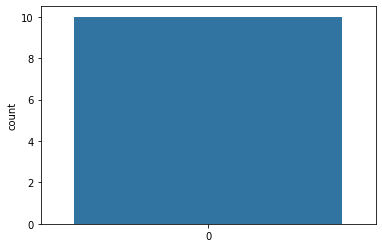

In [8]:
sns.countplot(x=df.isna().sum());

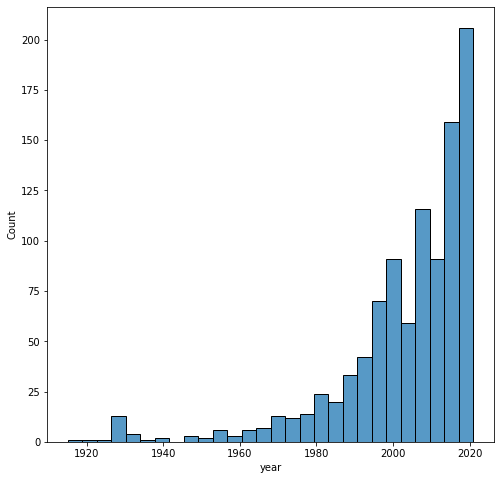

In [26]:
fig, ax = plt.subplots(figsize=(8, 8))
 

sns.histplot(x=df.year, ax=ax)
plt.show()

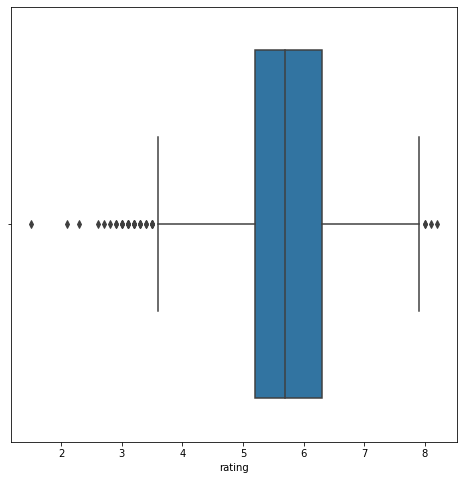

In [36]:
fig, ax = plt.subplots(figsize=(8, 8))
 

sns.boxplot(x=df.rating, ax=ax) # 5-6 most common
plt.show()

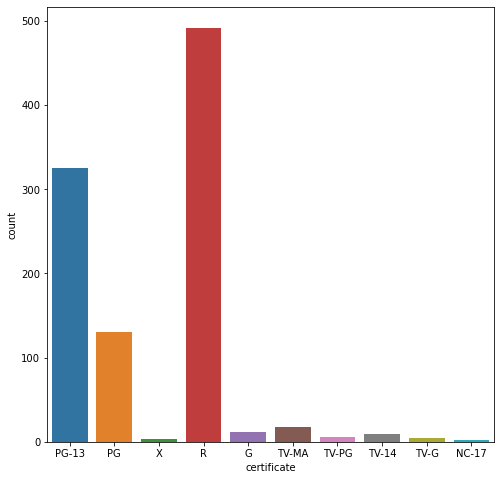

In [42]:
fig, ax = plt.subplots(figsize=(8, 8))
 

sns.countplot(x=df.certificate, ax=ax) # 5-6 most common
plt.show()

<p> I'll use bag of words for description </p>

In [43]:
from sklearn.feature_extraction.text import CountVectorizer

In [81]:
cv = CountVectorizer()
bag = cv.fit_transform(df2.description)
bag_df = pd.DataFrame(bag.todense())

<p> Now time to do data preprocessing </p>

In [82]:
df2.drop(['description'], axis=1, inplace=True)

y = df2.rating
df2.drop('rating', axis=1,inplace=True)

titles = df2.title
df2.drop('title', axis=1, inplace=True)

In [83]:
from sklearn.preprocessing import LabelEncoder

In [84]:
label = LabelEncoder()
df2.certificate = label.fit_transform(df2.certificate)

In [119]:
df2 = label.fit_transform(df2)

ValueError: y should be a 1d array, got an array of shape (1000, 7) instead.

In [133]:
df2 = df2.join(bag_df)

In [121]:
df2.director = label.fit_transform(df2.director)
df2.writer = label.fit_transform(df2.writer)

In [122]:
df2.actors = label.fit_transform(df2.actors)

In [92]:
df3 = df2.copy()

In [93]:
cat_features = df2.columns[df2.dtypes == "object"]
for i, col1 in enumerate(cat_features):
    for j, col2 in enumerate(cat_features[i + 1 :]):
        df3[col1 + "_" + col2] = df3[col1] + "_" + df3[col2]

In [97]:
df3 = pd.get_dummies(df3)

In [100]:
df3 = df3.join(bag_df)

In [101]:
df3.shape

(1000, 11476)

<p> Looking for best model </p>

In [106]:
from sklearn.linear_model import LassoCV, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor

from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error, mean_absolute_error

In [107]:
def learn_model(model, params, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33, random_state=42)
    
    model = model(**params)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    
    print(f"Mean squared error: {mse}")
    print(f"Mean absolute error: {mae}")
    
    return model

In [137]:
learn_model(CatBoostRegressor, {'learning_rate': .1, 'silent': True, 'random_seed': 42}, df2, y)

Mean squared error: 0.8215591179406299
Mean absolute error: 0.6749398601871728


In [134]:
learn_model(LinearRegression, {}, df2, y)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


Mean squared error: 1.0042782923781943
Mean absolute error: 0.7866463576627178


/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


LinearRegression()

In [135]:
learn_model(LassoCV, {'random_state':42, 'cv':3}, df2, y)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


Mean squared error: 0.7373900522287333
Mean absolute error: 0.6628380041112403


/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


LassoCV(cv=3, random_state=42)

In [136]:
learn_model(DecisionTreeRegressor, {'random_state': 42, 'max_depth': 3}, df2, y)

Mean squared error: 0.8692446349854211
Mean absolute error: 0.7009460927780865


/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


DecisionTreeRegressor(max_depth=3, random_state=42)

<h4> Best model is LassoCV </h4>